# Вторая задача

Решение проблемы проблемы числа Куранта могут быть следующие:


1.   Расчет задачи 2 раза. Первый раз подбирается подходящее значение числа Куранта. Второй раз расчет задачи с подхлдящим числом
2.   При возникновении проблемы $\sigma >= 1$ уменьшаем в два раза. Делаем перерасчет временного слоя со скорректированным числом Куранта.

Будем использовать 1 вариант.

Рассмотрим схему левый уголок:
$$ \frac{( u^{n+1}_{m} - u^n_{m} )}{\tau} + a \frac{( u^n_{m} - u^n_{m-1} )}{h} = 0 $$

Применим ее для уравнения:

$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \frac{\partial u}{\partial t} + \frac{1}{2} \frac{\partial u^2}{\partial x} = \frac{\partial u}{\partial t} + \frac{1}{2} \frac{\partial U}{\partial x} = 0 $$

Получаем

$$ \frac{( u^{n+1}_{m} - u^n_{m} )}{\tau} + \frac{1}{2} \frac{( U^n_{m} - U^n_{m-1} )}{h} = \frac{( u^{n+1}_{m} - u^n_{m} )}{\tau} + \frac{1}{2} \frac{( (u^n_{m})^2 - (u^n_{m-1})^2 )}{h} =\\ = \frac{( u^{n+1}_{m} - u^n_{m} )}{\tau} + \frac{( u^n_{m} + u^n_{m-1} )}{2} \frac{( u^n_{m} - u^n_{m-1} )}{h} = 0 $$

В таком случае число Куранта $$\sigma = \frac{( u^n_{m} + u^n_{m-1} )}{2} \frac{\tau}{h} $$

Для схемы Лакса-Вендорффа:

$$ \frac{( u^{n+1}_{m} - u^n_{m} )}{\tau} + \frac{( (u^n_{m+1})^2 - (u^n_{m-1})^2 )} {4h} - \frac{ \tau }{4} \frac{ (u^n_{m+1})^2 - 2(u^n_{m})^2 + (u^n_{m-1})^2 } {h^2} = \frac{( u^{n+1}_{m} - u^n_{m} )}{\tau} +\\ + \frac{( u^n_{m+1} + u^n_{m-1} )}{2} \frac{( u^n_{m+1} - u^n_{m-1} )} {2h} - \frac{ \tau }{4} (
  \frac{( u^n_{m+1} + u^n_{m} )( u^n_{m+1} - u^n_{m} )}{h^2} + \frac{( u^n_{m} + u^n_{m-1} )( u^n_{m} - u^n_{m-1} )}{h^2} )$$

  В данном случае можно выделить следующие $\sigma$:

  $$ \sigma = \frac{( u^n_{m+1} + u^n_{m-1} )}{2} \frac{\tau}{h} $$

  $$ \sigma_{+} = \frac{( u^n_{m+1} + u^n_{m} )}{2} \frac{\tau}{h} $$

  $$ \sigma_{-} = \frac{( u^n_{m} + u^n_{m-1} )}{2} \frac{\tau}{h} $$

  Для простоты решения задачу можно разбить на 3:

  $$ u_{+} = 0.5(u^n_{m+1} + u^n_{m}) - 0.5 \sigma_{+} ( u^n_{m+1} - u^n_{m} ) $$

  $$ u_{-} = 0.5(u^n_{m} + u^n_{m-1}) - 0.5 \sigma_{-} ( u^n_{m} - u^n_{m-1} ) $$

  $$ u^{n+1}_{m} = u^n_{m} - \sigma ( u_{+} -  u_{-} ) $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [2]:
def Solut( time, tau, u, sigma, Meth ):

  N = int(time / tau)

  res = np.copy( u )

  for i in np.arange( 1, N, 1 ):

    res, sig = Meth( sigma, res, 0.0 )

  N2 = int( N * sigma / sig )+2

  if N2 != N:

    res = np.copy( u )

    for i in np.arange( 1, N2, 1 ):

      res, sig = Meth( sig, res, 0.0 )

  return res

In [14]:
@njit
def Smooth( u ):

  res = np.copy( u )

  for j in np.arange( 2, u.size - 2, 1 ):

    d_pp = u[ j + 2 ] - u[ j + 1 ]
    d_p = u[ j + 1 ] - u[ j ]
    d_m = u[ j ] - u[ j - 1 ]
    d_mm = u[ j - 1 ] - u[ j - 2 ]

    if ( d_pp * d_p < 0 ) or ( d_p * d_m < 0 ):

      q_plus = d_p

    else:

      q_plus = 0.0

    if ( d_p * d_m < 0 ) or ( d_m * d_mm < 0 ):

      q_minus = d_m

    else:

      q_minus = 0.0

    res[ j ] = u[ j ] + 0.1 * ( q_plus - q_minus )

  return res


In [15]:
#Схема левый уголок
@njit
def LeftUg( sigma, u, f ):

  res = np.copy( u )

  for j in np.arange( 1, u.size, 1 ):

    res[ j ] = u[ j ] - sigma * ( u[ j ] ** 2 - u[ j - 1 ] ** 2 ) / 2. + tau * f

  return res, sigma

@njit
def LeftUg2( sigma, u, f ):

  res = np.copy( u )

  sig = 0.0

  sig = sigma

  for j in np.arange( 1, u.size, 1 ):

    res[ j ] = u[ j ] - sig * ( u[ j ] + u[ j - 1 ] ) * ( u[ j ] - u[ j - 1 ] ) * 0.5 + tau * f

    if np.fabs(sig * ( u[ j ] + u[ j - 1 ] ) * 0.5 ) >= 1.:

      sig = sig / 2.

  return res, sig

#cхема Лакса-Вендроффа
@njit
def LaksWen( sigma, u, f ):

  res = np.copy( u )

  for j in np.arange( 1, u.size - 1, 1 ):

    res[ j ] = u[ j ] - sigma * 0.25 * ( (u[j + 1])**2 - (u[j - 1])**2) + sigma ** 2 * 0.25 * ( (u[j + 1])**2 - 2. * (u[ j ])**2 + (u[j - 1])**2 )

  res = Smooth( res )

  return res, sigma

@njit
def LaksWen2( sigma, u, f ):

  res = np.copy( u )

  sig = 0.0

  sig = sigma

  for j in np.arange( 1, u.size - 1, 1 ):

    sig_all = ( u[j + 1] + u[j - 1] ) * sig / 2.

    sig_plus = ( u[j + 1] + u[j] ) * sig / 2.

    sig_minus = ( u[j] + u[j - 1] ) * sig / 2.

    u_plus = 0.5 * ( u[j + 1] + u[j] ) - sig_plus * 0.5 * ( u[j + 1] - u[j] )

    u_minus = 0.5 * ( u[j] + u[j-1] ) - sig_minus * 0.5 * ( u[j] - u[j-1] )

    res[ j ] = u[ j ] - sig_all * ( u_plus - u_minus )

    if sig_all >= 1. or sig_plus >= 1. or sig_minus >= 1.:

      sig = sig / 2.

  res = Smooth( res )

  return res, sig

In [16]:
h = 0.05
a = 1.
sigma = 0.05
tau = np.fabs(sigma * h / a)
x = np.arange( 0, 100, h )

In [17]:
u0 = np.zeros(x.size)
u0[int(x.size / 30):int(x.size / 10)] = 10

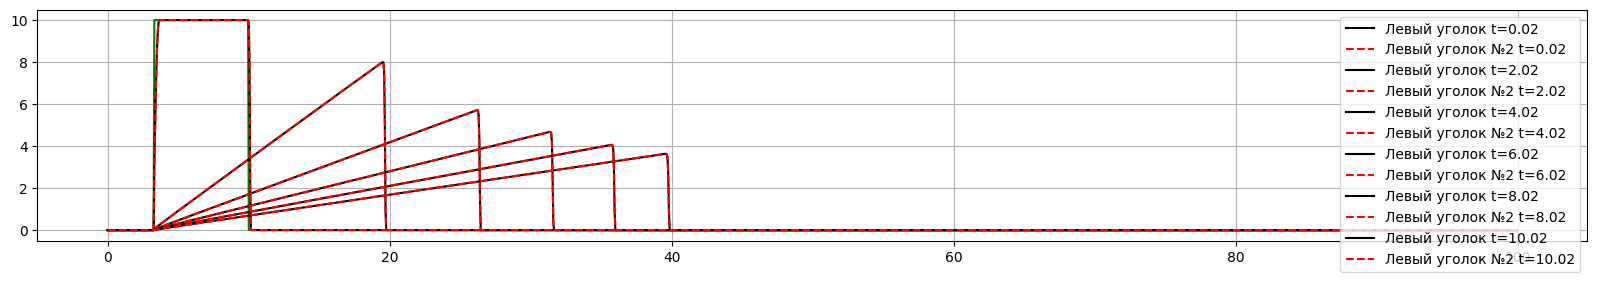

In [18]:
plt.figure( figsize = ( 20, 3 ) )
plt.plot(x, u0, 'g-')
for i in np.arange(0.02, 12, 2):
  Uul = Solut( i, tau, u0, sigma, LeftUg )
  Uul2 = Solut( i, tau, u0, sigma, LeftUg2 )
  plt.plot( x, Uul, 'k-', label = 'Левый уголок t='+str(i) )
  plt.plot( x, Uul2, 'r--', label = 'Левый уголок №2 t='+str(i) )
plt.grid()
plt.legend()

In [19]:
u0 = np.zeros(x.size)
u0[:int(x.size / 10)] = 10

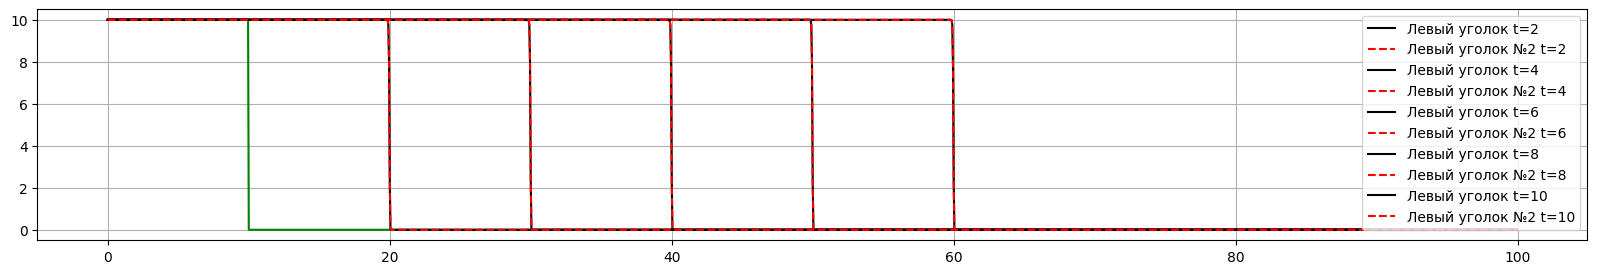

In [20]:
plt.figure( figsize = ( 20, 3 ) )
plt.plot(x, u0, 'g-')
for i in np.arange(2, 12, 2):
  Uul = Solut( i, tau, u0, sigma, LeftUg )
  Uul2 = Solut( i, tau, u0, sigma, LeftUg2 )
  plt.plot( x, Uul, 'k-', label = 'Левый уголок t='+str(i) )
  plt.plot( x, Uul2, 'r--', label = 'Левый уголок №2 t='+str(i) )
plt.grid()
plt.legend()

In [33]:
u0 = np.zeros(x.size)
u0[int(x.size / 30):int(x.size / 10)] = 10

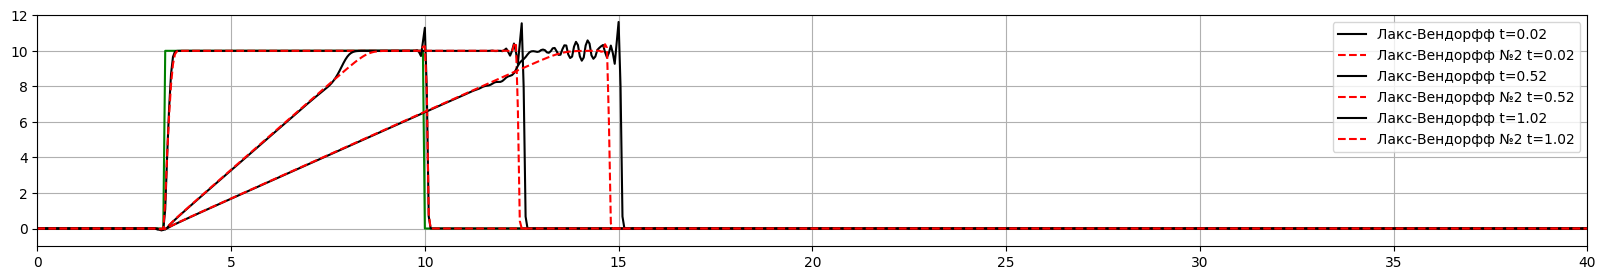

In [34]:
plt.figure( figsize = ( 20, 3 ) )
plt.plot(x, u0, 'g-')
for i in np.arange(0.02, 1.5, 0.5):
  ULW = Solut( i, tau, u0, sigma, LaksWen )
  ULW2 = Solut( i, tau, u0, sigma, LaksWen2 )
  plt.plot( x, ULW, 'k-', label = 'Лакс-Вендорфф t='+str(i) )
  plt.plot( x, ULW2, 'r--', label = 'Лакс-Вендорфф №2 t='+str(i) )
plt.grid()
plt.axis( [ 0,40, -1,12 ] )
plt.legend()

In [35]:
u0 = np.zeros(x.size)
u0[:int(x.size / 10)] = 10

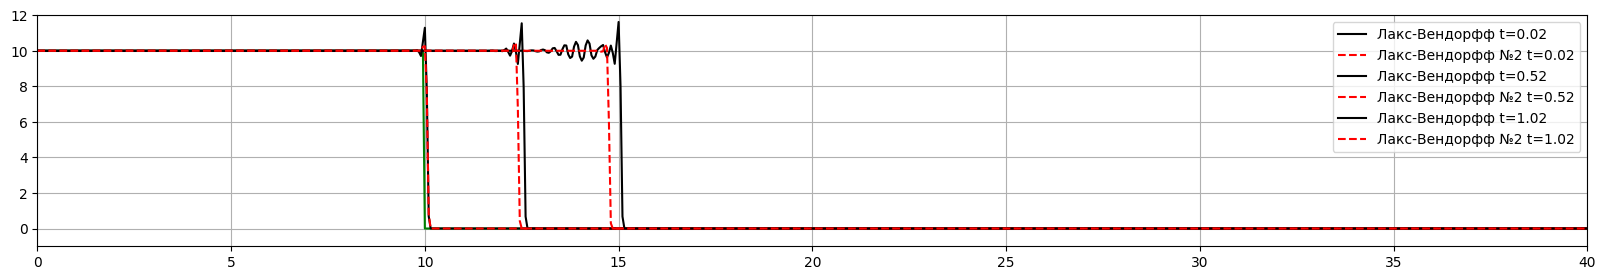

In [36]:
plt.figure( figsize = ( 20, 3 ) )
plt.plot(x, u0, 'g-')
for i in np.arange(0.02, 1.5, 0.5):
  ULW = Solut( i, tau, u0, sigma, LaksWen )
  ULW2 = Solut( i, tau, u0, sigma, LaksWen2 )
  plt.plot( x, ULW, 'k-', label = 'Лакс-Вендорфф t='+str(i) )
  plt.plot( x, ULW2, 'r--', label = 'Лакс-Вендорфф №2 t='+str(i) )
plt.grid()
plt.axis( [ 0,40, -1,12 ] )
plt.legend()